In [23]:
import pandas
import numpy
import matplotlib.pyplot as plt
import time

https://docs.python.org/3.4/library/multiprocessing.html

http://blog.adeel.io/2016/11/06/parallelize-pandas-map-or-apply/

In [26]:
import multiprocessing
from multiprocessing import Process
import os

https://stackoverflow.com/questions/47989418/multiprocessing-python-program-inside-docker

https://docs.docker.com/config/containers/resource_constraints/#configure-the-default-cfs-scheduler

In [27]:
print(multiprocessing.cpu_count())

2


In [3]:
def proc_info(title):
    print(title)
    print('\nmodule name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())

def myfunc(name):
    print('I am in myfunc')
    proc_info('function myfunc')
    print('end of myfunc', name)

In [4]:
if __name__ == '__main__':
    proc_info('main line') # display info about this process
    p = Process(target=myfunc, args=('bob',))
    p.start()
    p.join()

main line

module name: __main__
parent process: 7
process id: 1851
I am in myfunc
function myfunc

module name: __main__
parent process: 1851
process id: 1867
end of myfunc bob


https://docs.python.org/3.4/library/multiprocessing.html#using-a-pool-of-workers

In [5]:
from multiprocessing import Pool

In [6]:
def sq_fun(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(sq_fun, [1, 2, 3]))

[1, 4, 9]


Create random dataframe

https://stackoverflow.com/questions/32752292/how-to-create-a-data-frame-of-random-integers-with-pandas

In [7]:
df = pandas.DataFrame(
    numpy.random.randint(0,1000,size=(1000000, 4)), 
    columns=list('ABCD')
    )
print(df.shape)
df.head()

(1000000, 4)


,A,B,C,D
0,243,931,17,268
1,609,238,61,821
2,194,853,591,777
3,488,602,75,27
4,214,48,690,786


Create a new column ('K') that is double the value of entries in column 'A'

We'll use a lambda function 
https://www.w3schools.com/python/python_lambda.asp
to perform element-wise doubling.

"lambda" indicates an anonymous function -- a function without a name.<BR>
Normal functions are defined using the def keyword

In [8]:
start_time = time.time()
df['K'] = df['A'].apply(lambda x: x*2)
print(time.time() - start_time)

1.468287706375122


Loop over increasing number of rows to inspect scaling

In [9]:
number_of_tests=10
list_of_row_size=[100, 1000, 10000, 100000, 100000, 1000000]
#list_of_row_size=[100, 1000, 10000, 100000, 100000, 1000000, 10000000]#, 100000000, 1000000000]: # out of memory?

In [10]:
reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        df['K'] = df['A'].apply(lambda x: x*2)
        test_reslts.append(time.time() - start_time)
    reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 0.05876588821411133 for 100
elapsed time: 0.11935758590698242 for 1000
elapsed time: 0.4173727035522461 for 10000
elapsed time: 1.24751615524292 for 100000
elapsed time: 1.8871047496795654 for 100000
elapsed time: 11.14782977104187 for 1000000


Because the dataframe is large, it takes a while to perform the operations sequentially to each row

In [11]:
reslts

{100: 0.002639436721801758,
 1000: 0.003640413284301758,
 10000: 0.024470973014831542,
 100000: 0.06037137508392334,
 1000000: 0.8894369602203369}

As expected, computation time scales linearly with number of rows

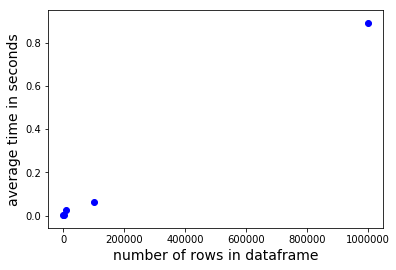

In [12]:
serial_x = list(reslts.keys()) # list_of_row_size
serial_y = list(reslts.values())
_=plt.scatter(serial_x,serial_y,color='blue')
#ax = plt.gca()
#ax.set_xscale('log')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)

With a linear fit:

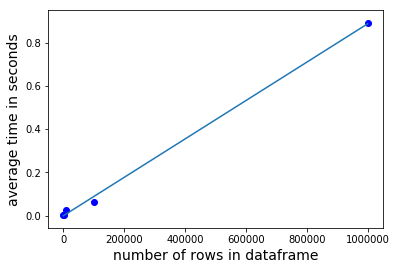

In [13]:
_=plt.scatter(serial_x,serial_y,color='blue')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x))) # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

Alternatively, we can spread the computation across the multiple cores

source: http://www.racketracer.com/2016/07/06/pandas-in-parallel/

In [14]:
num_partitions = 4 #number of partitions to split dataframe
num_cores = 4 #number of cores on your machine

In [15]:
def multiply_columns(data):
    data['K'] = data['A'].apply(lambda x: x*2)
    return data

In [16]:
def parallelize_dataframe(df, func,num_cores,num_partitions):
    df_split = numpy.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pandas.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [17]:
df = pandas.DataFrame(
    numpy.random.randint(0,1000,size=(1000000, 4)), 
    columns=list('ABCD')
    )
print(df.shape)

(1000000, 4)


In [18]:
df.head()

,A,B,C,D
0,437,172,393,423
1,462,388,667,426
2,761,856,358,233
3,857,191,295,896
4,486,376,698,711


In [19]:
start_time = time.time()
df = parallelize_dataframe(df, multiply_columns,num_cores,num_partitions)
print(time.time() - start_time,'seconds')

1.4016098976135254 seconds


Let's compare scaling

In [20]:
pool_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        df = parallelize_dataframe(df, multiply_columns,num_cores,num_partitions)
        test_reslts.append(time.time() - start_time)
    pool_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 2.949911594390869 for 100
elapsed time: 4.910930156707764 for 1000
elapsed time: 6.865859746932983 for 10000
elapsed time: 9.936662197113037 for 100000
elapsed time: 12.992438077926636 for 100000
elapsed time: 51.880513429641724 for 1000000


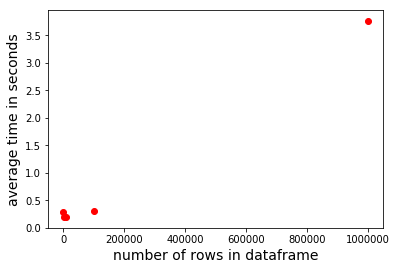

In [21]:
pool_x = list(pool_reslts.keys()) # list_of_row_size
pool_y = list(pool_reslts.values())
_=plt.scatter(pool_x,pool_y,color='red')
#ax = plt.gca()
#ax.set_xscale('log')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)

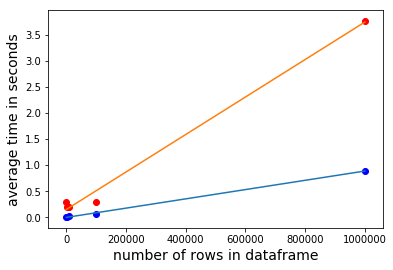

In [22]:
_=plt.scatter(serial_x,serial_y,color='blue')
_=plt.scatter(pool_x,pool_y,color='red')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x))) # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x))) # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python